# Simple analyses of COVID-19 disease using open data

This notebook demonstrates how to download publicly available COVID-19 case and death rates and do some simple analyses using Python Pandas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

## Download and index data

- [National data from the New York Times](https://www.nytimes.com/article/coronavirus-county-data-us.html)
- [Global data from Our World In Data](https://ourworldindata.org/coronavirus-source-data)

In [2]:
def process_nyt_data(url):
    """Download and format NYT data and organize"""
    data = pd.read_csv(NYT_DATA_URL)
    data.index = [pd.DatetimeIndex(data.pop('date')), data.pop('state'), data.pop('county')]
    # Remove county identifier (redundant)
    del data['fips']
    return data

NYT_DATA_URL = "https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv"
us_data = process_nyt_data(NYT_DATA_URL)
# Display the first few table entries
us_data[:10]

cases  deaths
date       state      county                    
2020-01-21 Washington Snohomish        1       0
2020-01-22 Washington Snohomish        1       0
2020-01-23 Washington Snohomish        1       0
2020-01-24 Illinois   Cook             1       0
           Washington Snohomish        1       0
2020-01-25 California Orange           1       0
           Illinois   Cook             1       0
           Washington Snohomish        1       0
2020-01-26 Arizona    Maricopa         1       0
           California Los Angeles      1       0

In [3]:
us_sum = us_data.sum(level='date')

In [6]:
# Download the international data
WORLD_DATA_URL = "https://covid.ourworldindata.org/data/ecdc/total_cases.csv"

def process_owid_data(url, name=None):
    data = pd.read_csv(url)
    data.index = pd.DatetimeIndex(data.pop('date'))
    del data['World']
    data.columns.name = 'nations'
    # Organize into [date, nation] rather than 'nation' as column
    data = data.unstack().swaplevel().sort_index()
    # Mark zeroes as unavailable
    data[data == 0] = np.nan
    data.name = name
    return data

world_cases = process_owid_data(WORLD_DATA_URL, name='cases')
world_deaths = process_owid_data(WORLD_DATA_URL.replace("cases", "deaths"), name='deaths')
world_data = pd.concat([world_cases, world_deaths], axis=1).dropna(how='all').fillna(0)
world_data[10:20]

cases  deaths
date       nations                
2020-01-10 China      59.0     0.0
2020-01-11 China      59.0     1.0
2020-01-12 China      59.0     1.0
2020-01-13 China      59.0     1.0
           Thailand    1.0     0.0
2020-01-14 China      59.0     1.0
           Thailand    1.0     0.0
2020-01-15 China      59.0     2.0
           Japan       1.0     0.0
           Thailand    1.0     0.0

In [14]:
world_sum = world_data.sum(level='date')

In [20]:
# Construct fake data with 20% day-over-day growth rates
alpha = np.log(1 + 0.20)
fake_dates = us_data.index.levels[0]
fake = pd.Series(np.exp(alpha * np.arange(len(fake_dates))), index=fake_dates)
# Second data set has no testing done for the first 30 days while case rate rises
fake_notests = fake.copy()
fake_notests.iloc[:30] = 0

## Plot case rates and growth rates

The following function plots the actual case counts, and additionally plots a "growth rate" based on smoothed case count data. The smoother is an [exponentially weighted mean](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows), which will preserve (asymptotically) exponential growth rates, which is the roughly the expected shape of a novel uncontrolled disease outbreak. The "fake" data demonstrates what an "ideal" infection would look like, with and without a delay in initial testing.

In [15]:
EWM_HALFLIFE = 5
SOURCE_TEXT = f"""\
USA data: {NYT_DATA_URL}
World data: {WORLD_DATA_URL}
Growth rate smoothed with exp-weighted mean, $T_{{1/2}}={EWM_HALFLIFE}$d"""
    
def plot_smoothed_rates(plot_data):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
    (count_ax, rate_ax) = axes
    for label, cases in plot_data.items():
        count_ax.semilogy(cases.index, cases, label=label)
        mean = cases.ewm(halflife=EWM_HALFLIFE).mean()
        rate = np.asarray(mean[1:]) / np.asarray(mean[:-1])
        rate_ax.plot(cases.index[1:], (rate - 1) * 100, label=label)
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.grid(zorder=0, color=(.8, .8, .8), linewidth=0.5)

    rate_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    rate_ax.set_ylabel('Daily growth rate (%)')
    count_ax.set_ylabel('Case count')
    count_ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=90)
    
    fig.tight_layout()
    fig.suptitle('COVID-19 cases and growth rate')
    fig.subplots_adjust(bottom=fig.subplotpars.bottom + .1, top=fig.subplotpars.top - 0.025, hspace=0)
    fig.text(.02, .02, SOURCE_TEXT, fontsize=8)
    fig.text(.98, .02, "Analysis: Seth R Johnson, Ph.D.\njohnsonsr@ornl.gov", fontsize=8, fontstyle='italic', ha='right')
    return (fig, axes)

/usr/local/anaconda3/envs/exnihilo/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/anaconda3/envs/exnihilo/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


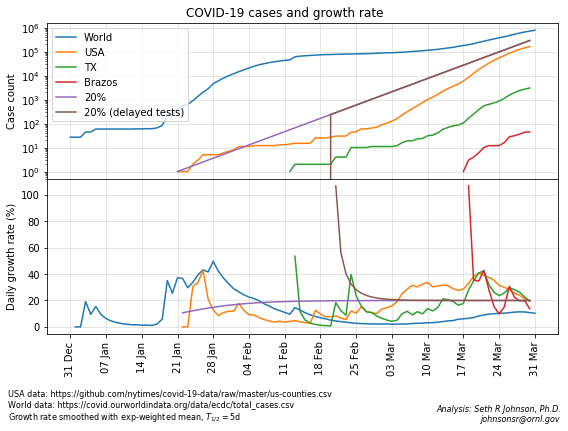

In [23]:
state_cases = us_data['cases'].xs('Texas', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TX': state_cases.sum(level='date'),
    'Brazos': state_cases.xs('Brazos', level='county'),
    '20%': fake,
    '20% (delayed tests)': fake_notests,
})
#fig.savefig('covid19-growth-college-station.png', dpi=150)

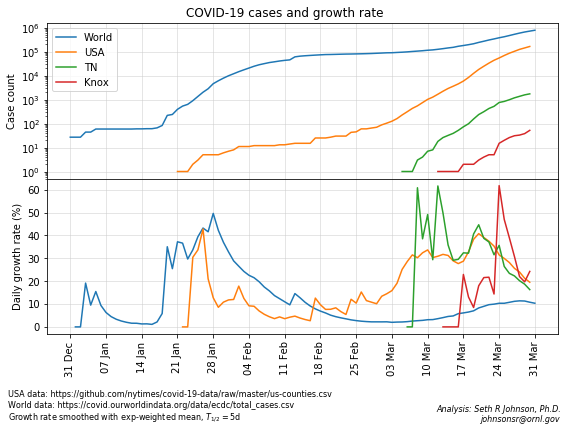

In [24]:
state_cases = us_data['cases'].xs('Tennessee', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TN': state_cases.sum(level='date'),
    'Knox': state_cases.xs('Knox', level='county'),
})
#fig.savefig('covid19-growth-knoxville.png', dpi=150)

In [28]:
cases_by_state = us_data['cases'].sum(level=['date','state']).unstack()

(0, 60)

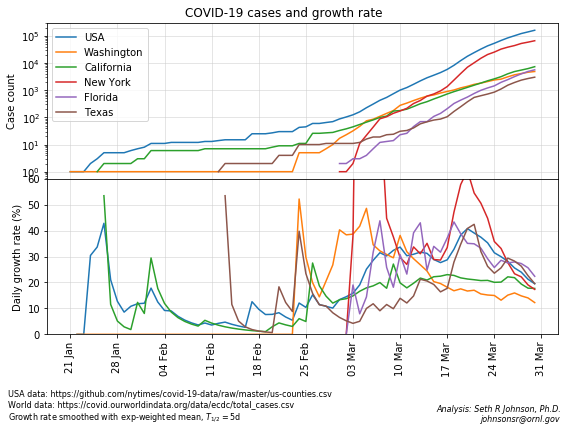

In [30]:
plot_data = {'USA': cases_by_state.sum(axis=1)}
for state in ['Washington', 'California', 'New York', 'Florida', 'Texas']:
    plot_data[state] = cases_by_state[state]
(fig, axes) = plot_smoothed_rates(plot_data)
axes[1].set_ylim([0, 60]);
#fig.savefig('covid19-growth-states.png', dpi=150)

## Additional plotting examples

[Pandas](https://pandas.pydata.org) has a lot of power but has a steep learning curve. These examples show a few ways to process the data above and quickly visualize using the builtin plot function.

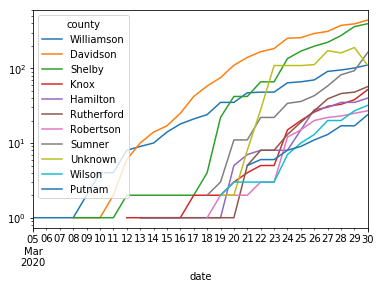

In [32]:
# Select Tennessee cases and make a table of date vs county
tenn_by_county = us_data['cases'].xs('Tennessee', level="state").unstack('county')
# Find counties with at least 20 cases at present
several_presently = tenn_by_county.iloc[-1] >= 20
# Plot those counties on a log scale
tenn_by_county.T[several_presently].T.plot(logy=True);

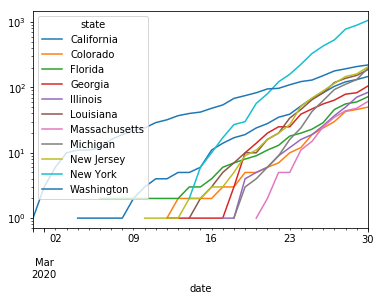

In [33]:
deaths = us_data['deaths'].sum(level=['date', 'state']).unstack('state')
many_deaths = deaths.iloc[-1] >= 50
deaths_plot = deaths.T[many_deaths].T
deaths_plot[deaths_plot == 0] = np.nan
deaths_plot.dropna(how='all').plot(logy=True);